# 离群点分析
本文件将分析HT29的features与smiles数据，使用以下6种离散点分析方法：  
**基于统计**  
**基于距离**  
**基于密度**  
**两阶段离群点挖掘方法TOD**  
**基于聚类的离群挖掘方法CBOD**  
**基于聚类的动态数据的离群点检测**  
来分别对药品协同的化学性质离群点和结构性质离群点进行分析，对比两个特征空间的离群点差异

In [60]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
from matplotlib_venn import venn2
import plotly.express as px
import plotly.graph_objects as go
RDLogger.DisableLog('rdApp.*')

## 数据清洗
### 文件读取、缺失值比例检测与记录、样本筛选(80%)、使用KNN进行缺失值填充、标准化

In [61]:
def load_log_and_preprocess(folder_path):
    """
    流程：
    1. 读取数据
    2. [关键步骤] 计算原始数据的每行缺失比例，并保存到 output/txt 文件
    3. 过滤：删除缺失率 > 80% 的样本
    4. 填充：对剩余样本进行均值填充
    5. 标准化：Z-Score
    """
    
    # --- 0. 准备工作 ---
    dataset_name = os.path.basename(folder_path) # 获取文件夹名，如 CO_HT29
    
    # 确保 output 文件夹存在
    output_dir = 'output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    feat_path = os.path.join(folder_path, 'dataset_features.csv')
    smile_path = os.path.join(folder_path, 'dataset_smiles.csv')
    
    if not os.path.exists(folder_path):
        print(f"错误: 找不到文件夹 {folder_path}")
        return None, None

    print(f"\n{'='*20} 正在处理: {dataset_name} {'='*20}")

    # --- 1. 读取原始数据 ---
    try:
        df_features = pd.read_csv(feat_path)
        df_smiles = pd.read_csv(smile_path)
    except Exception as e:
        print(f"读取失败: {e}")
        return None, None

    # 切分特征(X) 和 标签(y)
    # 前416列是特征 (0-415)，后面是标签
    X_raw = df_features.iloc[:, :416]
    y_raw = df_features.iloc[:, 416:]
    
    print(f"原始数据读取成功: {X_raw.shape[0]} 行, {X_raw.shape[1]} 特征列")

    # --- 2. [核心步骤] 记录缺失值比例 (在填充之前!) ---
    # 计算每一行的缺失比例
    missing_ratios = X_raw.isnull().mean(axis=1)
    
    log_filename = f"missing_ratio_log_{dataset_name}.txt"
    log_path = os.path.join(output_dir, log_filename)
    
    print(f"正在记录原始缺失值分布到 -> {log_path}")
    
    with open(log_path, 'w', encoding='utf-8') as f:
        f.write(f"Dataset: {dataset_name}\n")
        f.write(f"Raw_Total_Rows: {len(X_raw)}\n")
        f.write("Description: 此文件记录了原始数据的缺失比例。比例 > 0.8 的行将在后续步骤中被删除。\n")
        f.write("-" * 40 + "\n")
        f.write("Row_Index\tMissing_Ratio\tStatus\n") # 表头
        
        for idx, ratio in missing_ratios.items():
            # 标记一下该行稍后会被 Drop 还是 Keep
            status = "DROP" if ratio > 0.8 else "KEEP"
            f.write(f"{idx}\t{ratio:.6f}\t{status}\n")
            
    print("-> 日志写入完毕。")

    # --- 3. 样本筛选 (删除缺失 > 80% 的行) ---
    # 找出要删除的索引
    drop_indices = missing_ratios[missing_ratios > 0.8].index.tolist()
    
    X_clean = X_raw
    y_clean = y_raw
    df_smiles_clean = df_smiles
    
    if len(drop_indices) > 0:
        print(f"\n[数据清洗] 发现 {len(drop_indices)} 个样本缺失率 > 80%，正在删除...")
        # 同步删除特征、标签、SMILES
        X_clean = X_raw.drop(drop_indices).reset_index(drop=True)
        y_clean = y_raw.drop(drop_indices).reset_index(drop=True)
        df_smiles_clean = df_smiles.drop(drop_indices).reset_index(drop=True)
        print(f"-> 删除完成。剩余样本数: {X_clean.shape[0]}")
    else:
        print("\n[数据清洗] 没有样本超过 80% 缺失阈值，无需删除。")

    # --- 4. 使用 KNN 填充缺失值 (先标准化再填充) ---
    # 检查清洗后的数据里是否还有 NaN (比如缺失率 20% 的行)
    remaining_nans = X_clean.isnull().sum().sum()

    if remaining_nans > 0:
        print(f"[填充缺失] 剩余缺失值总数: {remaining_nans}，先对非缺失值做 Z-Score 标准化然后使用 KNN 填充...")

        # 计算列的均值和标准差，忽略 NaN
        X_vals = X_clean.astype(float)
        col_means = np.nanmean(X_vals.values, axis=0)
        col_stds = np.nanstd(X_vals.values, axis=0)
        # 避免标准差为0导致除以0
        col_stds[col_stds == 0] = 1.0

        # 对非 NaN 值进行标准化，NaN 会被保留
        X_standardized = (X_vals - col_means) / col_stds

        # KNN 填充在标准化空间进行
        knn_imputer = KNNImputer(n_neighbors=5)
        X_imputed_arr = knn_imputer.fit_transform(X_standardized)

        # imputer 返回的是 numpy array（标准化后的值），保持为 DataFrame
        X_clean = pd.DataFrame(X_imputed_arr, columns=X_clean.columns)
        print("-> KNN 填充完成（结果为标准化后的特征）。")
    else:
        # 如果没有缺失，按常规对整个数据做标准化
        print("[填充缺失] 数据完整，无需 KNN 填充，接着进行 Z-Score 标准化...")
        scaler = StandardScaler()
        X_scaled_arr = scaler.fit_transform(X_clean)
        X_clean = pd.DataFrame(X_scaled_arr, columns=X_clean.columns)

    # --- 5. （此时）数据已为标准化特征，拼接回完整表格 (特征 + 标签)
    df_final = pd.concat([X_clean, y_clean], axis=1)
    
    print(f"处理结束! 最终数据维度: {df_final.shape}")
    print("-" * 50 + "\n")
    
    return df_final, df_smiles_clean

# ==========================================
# 执行主程序
# ==========================================

dir_hct116 = 'CO_HCT-116'
dir_ht29 = 'CO_HT29'

# 1. 处理 HCT-116
df_hct116_ready, df_hct116_smiles_ready = load_log_and_preprocess(dir_hct116)

# 2. 处理 HT-29
df_ht29_ready, df_ht29_smiles_ready = load_log_and_preprocess(dir_ht29)

print(f"所有日志文件已生成至: {os.path.abspath('output')}")


==================== 正在处理: CO_HCT-116 ====================
原始数据读取成功: 5251 行, 416 特征列
正在记录原始缺失值分布到 -> output\missing_ratio_log_CO_HCT-116.txt
-> 日志写入完毕。

[数据清洗] 没有样本超过 80% 缺失阈值，无需删除。
[填充缺失] 剩余缺失值总数: 3680，先对非缺失值做 Z-Score 标准化然后使用 KNN 填充...
-> KNN 填充完成（结果为标准化后的特征）。
处理结束! 最终数据维度: (5251, 418)
--------------------------------------------------


==================== 正在处理: CO_HT29 ====================
原始数据读取成功: 5279 行, 416 特征列
正在记录原始缺失值分布到 -> output\missing_ratio_log_CO_HT29.txt
-> 日志写入完毕。

[数据清洗] 没有样本超过 80% 缺失阈值，无需删除。
[填充缺失] 剩余缺失值总数: 3624，先对非缺失值做 Z-Score 标准化然后使用 KNN 填充...
-> KNN 填充完成（结果为标准化后的特征）。
处理结束! 最终数据维度: (5279, 418)
--------------------------------------------------

所有日志文件已生成至: E:\file\postgraduate\机器学习\期末\ML期末作业\output


## 全局设置
### 设置plt绘图参数、定义输出文件夹

In [62]:
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 正常显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# 定义输出文件夹
OUTPUT_DIR = 'output'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# 基于Feature的离群点检测
## 数据预处理
### 数据集选择、特征提取与降维（保留95%方差）

In [63]:
# --- 1. 选择要分析的数据集 ---
current_dataset_name = "HT-29_FEATURE"
df_current = df_ht29_ready           
df_smiles_current = df_ht29_smiles_ready

print(f"当前分析对象: {current_dataset_name}")

# --- 2. 提取特征并先做 PCA(0.95) 降维，供后续离群点检测使用 ---
# 提取前416列特征矩阵
X = df_current.iloc[:, :416].values

# 先用 PCA 保留 95% 方差，降维用于后续离群点检测
# 使用 svd_solver='full' 以保证 n_components=0.95 时行为一致
pca_reducer = PCA(n_components=0.95, svd_solver='full')
X_reduced = pca_reducer.fit_transform(X)
print(f"[PCA] 原始维度: {X.shape[1]} -> 降维后: {X_reduced.shape[1]} (保留 95% 方差)")

# 为了绘图，再在降维后的数据上做一次 2D PCA，保证可视化和检测使用相同（或相似）的空间
if X_reduced.shape[1] >= 2:
    pca2 = PCA(n_components=2)
    X_pca = pca2.fit_transform(X_reduced)
else:
    # 如果降维后只有 1 维，为了可视化构造第二列为 0
    X_pca = np.hstack([X_reduced, np.zeros((X_reduced.shape[0], 1))])

# 初始化一个 DataFrame 用来存结果
outlier_flags = pd.DataFrame(index=df_current.index)

print("特征提取与 PCA 降维完成。")

当前分析对象: HT-29_FEATURE
[PCA] 原始维度: 416 -> 降维后: 75 (保留 95% 方差)
特征提取与 PCA 降维完成。


## 1.基于统计的离群点分析

正在运行统计法检测...
图片已保存: output\HT-29_FEATURE_1_Statistical.png


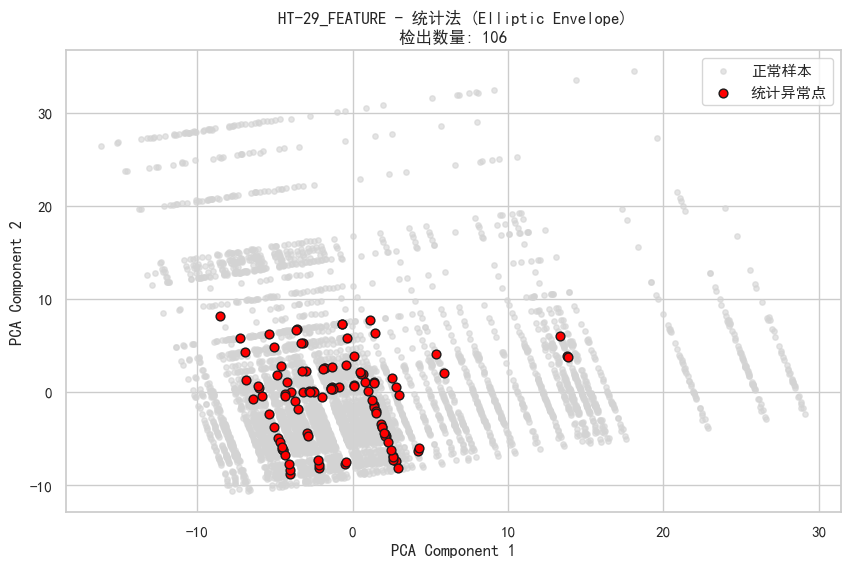

In [64]:
# --- 方法 1: 基于统计 (Statistical) ---
print(f"正在运行统计法检测...")

# 设定离群阈值
contamination = 0.02

# 1. 计算 (在降维后的空间上进行检测)
# support_fraction=0.9 表示使用 90% 的数据来拟合椭圆，剩下的作为噪点参考
ee = EllipticEnvelope(contamination=contamination, support_fraction=0.9, random_state=42)
y_pred_stat = ee.fit_predict(X_reduced) # 1正常, -1异常

# 记录结果 (True 为异常)
outlier_flags['Stat'] = (y_pred_stat == -1)

# 2. 绘图
plt.figure(figsize=(10, 6))
# 画正常点
plt.scatter(X_pca[~outlier_flags['Stat'], 0], X_pca[~outlier_flags['Stat'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常样本')
# 画异常点
plt.scatter(X_pca[outlier_flags['Stat'], 0], X_pca[outlier_flags['Stat'], 1], 
            c='red', s=40, edgecolor='k', label='统计异常点')

plt.title(f'{current_dataset_name} - 统计法 (Elliptic Envelope)\n检出数量: {outlier_flags["Stat"].sum()}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# 3. 保存
save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_1_Statistical.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")

plt.show()

## 2.基于距离的离群点分析

正在运行距离法检测...
图片已保存: output\HT-29_FEATURE_2_Distance.png


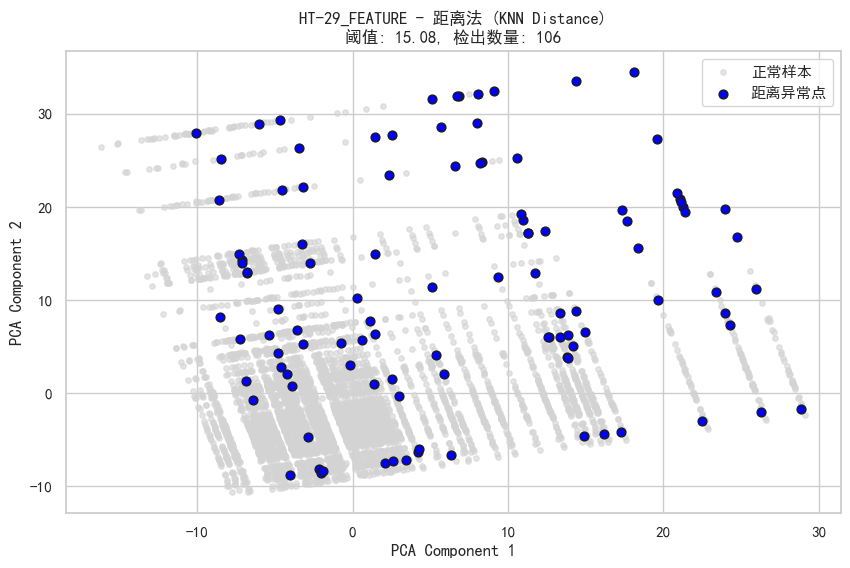

In [65]:
# --- 方法 2: 基于距离 (Distance) ---
print(f"正在运行距离法检测...")

k = 5
# 距离法使用降维后的数据
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_reduced)

# 1.计算距离
distances, _ = knn.kneighbors(X_reduced)
kth_dist = distances[:, -1] # 取第 k 个邻居的距离

# 确定阈值 (距离最远的 top 2%)
threshold_dist = np.percentile(kth_dist, 100 * (1 - contamination))

# 记录结果
outlier_flags['Dist'] = kth_dist > threshold_dist

# 2.绘图
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[~outlier_flags['Dist'], 0], X_pca[~outlier_flags['Dist'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常样本')
plt.scatter(X_pca[outlier_flags['Dist'], 0], X_pca[outlier_flags['Dist'], 1], 
            c='blue', s=40, edgecolor='k', label='距离异常点')

plt.title(f'{current_dataset_name} - 距离法 (KNN Distance)\n阈值: {threshold_dist:.2f}, 检出数量: {outlier_flags["Dist"].sum()}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# 3. 保存
save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_2_Distance.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")

plt.show()

## 3.基于密度的离群点分析

正在运行密度法检测...
图片已保存: output\HT-29_FEATURE_3_Density.png


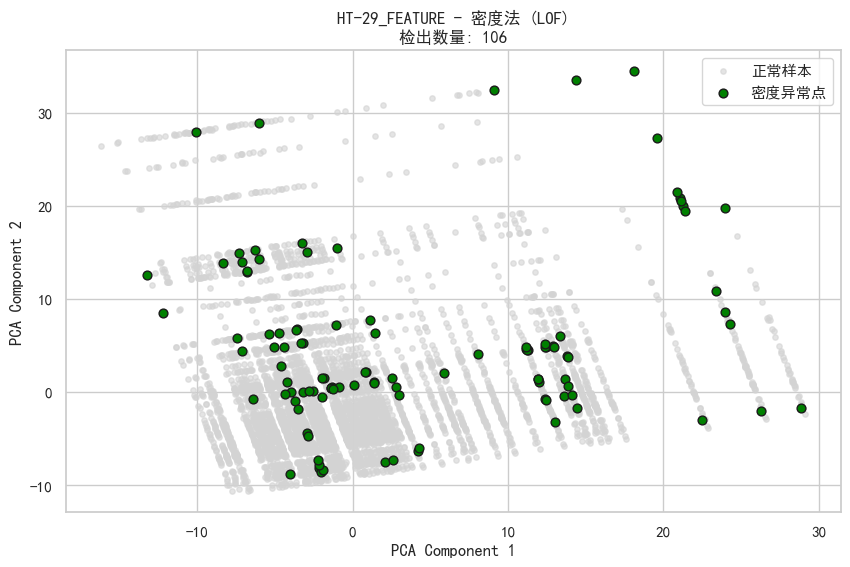

In [66]:
# --- 方法 3: 基于密度 (Density) ---
print(f"正在运行密度法检测...")

# LOF 在降维后的空间上运行
lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
y_pred_lof = lof.fit_predict(X_reduced) # -1 为异常

# 记录结果
outlier_flags['Density'] = (y_pred_lof == -1)

# 绘图
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[~outlier_flags['Density'], 0], X_pca[~outlier_flags['Density'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常样本')
plt.scatter(X_pca[outlier_flags['Density'], 0], X_pca[outlier_flags['Density'], 1], 
            c='green', s=40, edgecolor='k', label='密度异常点')

plt.title(f'{current_dataset_name} - 密度法 (LOF)\n检出数量: {outlier_flags["Density"].sum()}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_3_Density.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")

plt.show()

## 4.基于聚类的离群点分析
### 4.1两阶段离群点挖掘方法（TOD）

正在运行 TOD (Two-Phase Outlier Detection) 方法...
   [TOD统计] Ave_OF: 20.3432, Dev_OF: 5.2022, Beta: 2
   [TOD统计] 阈值: 30.7476
图片已保存: output\HT-29_FEATURE_4_TOD.png


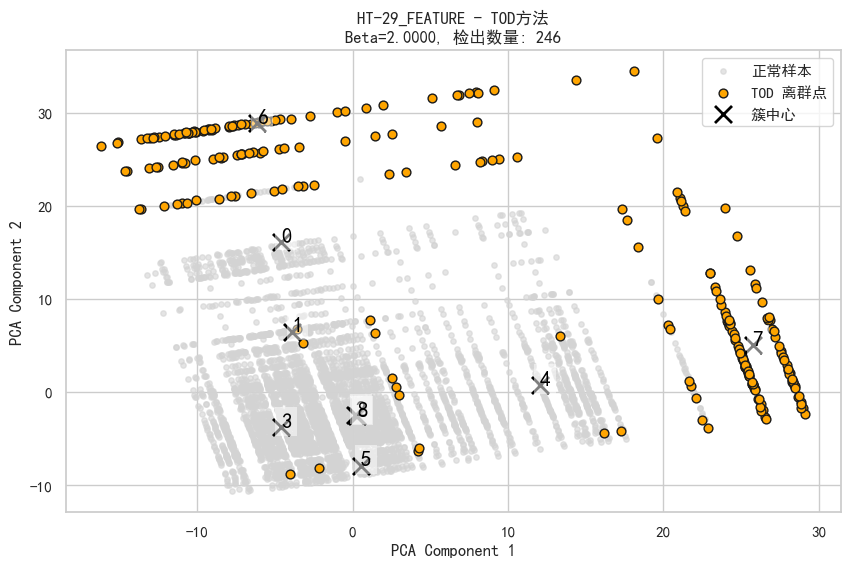

In [67]:
# --- 4.1: 两阶段离群点挖掘方法（TOD） ---
print(f"正在运行 TOD (Two-Phase Outlier Detection) 方法...")

# 参数设置
n_clusters = 9
beta = 2  

# ---------------------------------------------------------
# 第一阶段：聚类 (Phase 1: Clustering)
# ---------------------------------------------------------
# 使用 K-Means 对降维后的数据进行聚类
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_reduced)

# ---------------------------------------------------------
# 第二阶段：计算离群因子 OF3 (Phase 2: Calculate Outlier Factor)
# ---------------------------------------------------------

# 1. 计算距离 d(p, Cj): 所有点到所有簇中心的距离
# kmeans.transform 返回矩阵形状为 (样本数, 簇数量)，正是我们要的距离矩阵
dist_matrix = kmeans.transform(X_reduced)

# 2. 计算权重 |Cj| / |D|
# 获取每个簇的样本数量 (|Cj|)
labels = kmeans.labels_
cluster_sizes = np.bincount(labels, minlength=n_clusters)
total_samples = len(X_reduced)

# 计算每个簇的权重系数
cluster_weights = cluster_sizes / total_samples

# 3. 计算 OF3(p): 加权平均距离
# 公式: Sum( (Size_j / Total) * dist_j )
# 利用矩阵乘法: (N, k) dot (k,) -> (N,)，相当于对每一行进行了加权求和
of3_scores = np.dot(dist_matrix, cluster_weights)

# ---------------------------------------------------------
# 第三阶段：判定 (Thresholding)
# ---------------------------------------------------------
# 计算 OF3 的统计量
ave_of = np.mean(of3_scores)  # Ave_OF
dev_of = np.std(of3_scores)   # Dev_OF

# 设定阈值: Ave_OF + beta * Dev_OF
threshold_tod = ave_of + beta * dev_of

# 记录结果 (True 为异常)
outlier_flags['TOD'] = of3_scores >= threshold_tod

# 打印
print(f"   [TOD统计] Ave_OF: {ave_of:.4f}, Dev_OF: {dev_of:.4f}, Beta: {beta}")
print(f"   [TOD统计] 阈值: {threshold_tod:.4f}")

# =========================================================
# 绘图
# =========================================================
plt.figure(figsize=(10, 6))

# 1. 画正常点
plt.scatter(X_pca[~outlier_flags['TOD'], 0], X_pca[~outlier_flags['TOD'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常样本')

# 2. 画异常点 (TOD 关注的是离中心远的点)
plt.scatter(X_pca[outlier_flags['TOD'], 0], X_pca[outlier_flags['TOD'], 1], 
            c='orange', s=40, edgecolor='k', label='TOD 离群点')

# 3. 绘制簇中心

pca_model = pca2

if pca_model is not None:
    try:
        # 获取聚类中心 (来自 TOD 阶段训练的 kmeans)
        # 尝试将中心点投影到 2D 画布上
        centers_2d = pca_model.transform(kmeans.cluster_centers_)
        
        # 绘制中心点 (黑色 X)
        plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
                    marker='x', s=150, linewidths=2, color='black', label='簇中心')
        
        # 标上数字 ID
        for i, (cx, cy) in enumerate(centers_2d):
            plt.text(cx, cy, str(i), fontsize=15, color='black', weight='bold',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')) # 白底防遮挡
            
    except Exception as e:
        # 维度不匹配时(例如 kmeans 是 75维, pca 是 416维)，只打印警告不报错
        print(f"警告: 无法绘制簇中心，维度可能不匹配 ({e})。仅绘制样本分布。")
else:
    print("提示: 未找到 PCA 模型对象，仅绘制样本点。")
# ---------------------------------------------------------

plt.title(f'{current_dataset_name} - TOD方法\nBeta={beta:.4f}, 检出数量: {outlier_flags["TOD"].sum()}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_4_TOD.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")

plt.show()

### 4.2基于聚类的离群挖掘方法 （CBOD）


正在运行 CBOD 方法...
   [复用] 簇数量 K=9
   [CBOD] 簇离群因子 OF4 统计 (按偏离程度降序):
   Rank | ID | Size | OF4 Score | Cumulative %
   --------------------------------------------------
      1 |  6 |   64 | 39.835909  | 1.21%
      2 |  7 |  103 | 32.896110  | 3.16%
   --------------------------------------------------
   -> 累积离群比例 3.16% 已满足阈值 (>= 2.0%)
   -> 判定离群簇 ID: [6, 7]
图片已保存: output\HT-29_FEATURE_4_CBOD.png


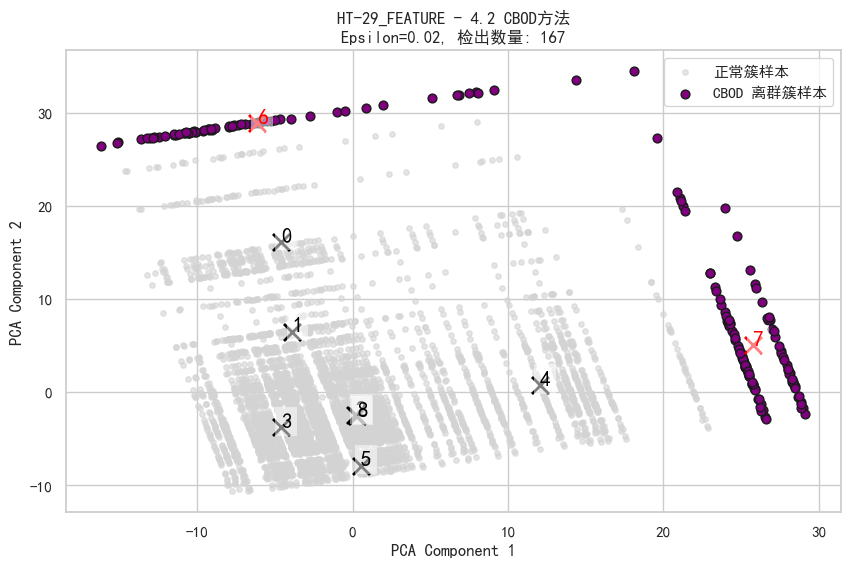

In [68]:
# --- 4.2: CBOD 方法---
print(f"\n正在运行 CBOD 方法...")

# 参数设置
# epsilon: 我们希望筛选出的离群样本比例 (即 PPT 中的 0 < epsilon < 1)
epsilon = 0.02 

# =========================================================
# 1. 复用聚类信息 (Reuse Clustering Info)
# =========================================================
# 直接使用 TOD 阶段的 kmeans 模型和权重
# centroids: 簇中心坐标 (k, 75)
centroids = kmeans.cluster_centers_
# cluster_weights: 之前算好的权重 |Cj|/|D|
# cluster_sizes: 之前算好的簇大小 |Cj|

print(f"   [复用] 簇数量 K={len(centroids)}")

# =========================================================
# 2. 计算 OF4 (根据 PPT 公式)
# =========================================================
# 公式: OF4(Ci) = Sum( (|Cj|/|D|) * d(Ci, Cj) )

# 计算簇中心之间的距离矩阵 d(Ci, Cj)
# centroid_dist_matrix[i, j] 表示第 i 个簇中心和第 j 个簇中心的距离
centroid_dist_matrix = euclidean_distances(centroids, centroids)

# 利用矩阵乘法一次性算出所有 OF4
# (K, K) dot (K,) -> (K,)
of4_scores_cbod = np.dot(centroid_dist_matrix, cluster_weights)

# 整理每个簇的信息以便排序
cbod_stats = []
for i in range(len(centroids)):
    cbod_stats.append({
        'cluster_id': i,
        'size': cluster_sizes[i],
        'of4': of4_scores_cbod[i]
    })

# =========================================================
# 3. 排序与判定 (Ranking & Determination)
# =========================================================

# 按 OF4(Ci) 递减顺序重新排列 (离大部队越远的簇排在越前面)
sorted_cbod = sorted(cbod_stats, key=lambda x: x['of4'], reverse=True)

# 寻找最小的 b，使得累积样本占比 >= epsilon
current_sum = 0
outlier_cluster_ids = []

print(f"   [CBOD] 簇离群因子 OF4 统计 (按偏离程度降序):")
print(f"   Rank | ID | Size | OF4 Score | Cumulative %")
print(f"   {'-'*50}")

for rank, c in enumerate(sorted_cbod):
    current_sum += c['size']
    cumulative_ratio = current_sum / total_samples
    
    print(f"   {rank+1:4d} | {c['cluster_id']:2d} | {c['size']:4d} | {c['of4']:.6f}  | {cumulative_ratio*100:.2f}%")
    
    # 只要累积比例还没超过 epsilon，或者这是第一个簇（至少得选一个），就加入离群名单
    if len(outlier_cluster_ids) == 0 or (current_sum - c['size']) / total_samples < epsilon:
         outlier_cluster_ids.append(c['cluster_id'])
    
    # 检查是否刚刚跨过 epsilon 阈值
    if cumulative_ratio >= epsilon:
        print(f"   {'-'*50}")
        print(f"   -> 累积离群比例 {cumulative_ratio*100:.2f}% 已满足阈值 (>= {epsilon*100}%)")
        print(f"   -> 判定离群簇 ID: {outlier_cluster_ids}")
        break

# 标记样本
# np.isin 用于判断 labels 中的每个元素是否在 outlier_cluster_ids 列表中
outlier_flags['CBOD'] = np.isin(labels, outlier_cluster_ids)

# =========================================================
# 4. 绘图
# =========================================================
plt.figure(figsize=(10, 6))

# 1. 画正常点 (属于 normal 簇的点)
plt.scatter(X_pca[~outlier_flags['CBOD'], 0], X_pca[~outlier_flags['CBOD'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常簇样本')

# 2. 画异常点 (整个离群簇)
plt.scatter(X_pca[outlier_flags['CBOD'], 0], X_pca[outlier_flags['CBOD'], 1], 
            c='purple', s=40, edgecolor='k', label='CBOD 离群簇样本')

# 3. 标记簇中心 ID
pca_model = pca2

if pca_model is not None:
    try:
        # 将 75维 的簇中心投影到 2D
        # centroids 来自于复用的 kmeans.cluster_centers_
        centers_2d = pca_model.transform(centroids)
        
        # 遍历绘制每个中心
        for i, (cx, cy) in enumerate(centers_2d):
            # 逻辑：如果该簇 ID 在离群名单里，数字标红，否则标黑
            text_color = 'red' if i in outlier_cluster_ids else 'black'
            font_weight = 'bold' if i in outlier_cluster_ids else 'normal'
            
            # 画中心位置 (X号)
            plt.scatter(cx, cy, marker='x', s=150, linewidths=2, color=text_color)
            
            # 写数字 ID
            plt.text(cx, cy, str(i), fontsize=15, color=text_color, weight=font_weight,
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')) # 加个白底好认
            
    except Exception as e:
        print(f"警告: 无法绘制簇中心，维度可能不匹配 ({e})")
else:
    print("提示: 未找到 PCA 模型对象，仅绘制样本点。")
# ---------------------------------------------------------

plt.title(f'{current_dataset_name} - 4.2 CBOD方法\nEpsilon={epsilon}, 检出数量: {outlier_flags["CBOD"].sum()}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_4_CBOD.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")

plt.show()

## 5.基于聚类的动态数据的离群点检测
本部分使用通过划分数据去训练一个可以流式检测离群点的模型，该模型可在新数据进入时实时更新离群点判断依据。
第一步使用80%的数据进行聚类，CBOD的逻辑去筛选离群簇，建立基础模型；
第二步利用使用额外20%的数据流式输入模型，根据INN算法来判断该点属于是否属于离群簇、正常簇、候选离群点。输入新数据后将实时更新离群簇判断依据。

In [69]:
# 参数设置
n_clusters_dynamic = 9
epsilon = 0.02 

带索引切分数据，一遍后续回溯数据时记录离群点

In [70]:
# indices_train/test 用于记录原始行号，以便最后填回 outlier_flags
X_train, X_test, idx_train, idx_test = train_test_split(
    X_reduced, df_current.index, test_size=0.2, random_state=42
)

print(f"   [数据切分] 训练集: {len(X_train)}, 测试集: {len(X_test)}")

   [数据切分] 训练集: 4223, 测试集: 1056


#### 模型建立

In [71]:
kmeans_dyn = KMeans(n_clusters=n_clusters_dynamic, random_state=42, n_init=10)
kmeans_dyn.fit(X_train)
labels_train = kmeans_dyn.labels_
centroids = kmeans_dyn.cluster_centers_

# --- 确定离群簇 (CBOD逻辑) ---
train_sizes = np.bincount(labels_train, minlength=n_clusters_dynamic)
train_weights = train_sizes / len(X_train)
centroid_dist = euclidean_distances(centroids, centroids)
of4_scores = np.dot(centroid_dist, train_weights)

# 排序并筛选离群簇
cluster_info = [{'id': i, 'size': s, 'of4': o} for i, s, o in zip(range(n_clusters_dynamic), train_sizes, of4_scores)]
sorted_clusters = sorted(cluster_info, key=lambda x: x['of4'], reverse=True)

outlier_cluster_ids = []
curr_sum = 0
for c in sorted_clusters:
    outlier_cluster_ids.append(c['id'])
    curr_sum += c['size']
    if curr_sum / len(X_train) >= epsilon:
        break

# --- 确定簇半径 (Radius) ---
cluster_radii = np.zeros(n_clusters_dynamic)
train_dists = kmeans_dyn.transform(X_train)
for i in range(n_clusters_dynamic):
    dists = train_dists[labels_train == i, i]
    if len(dists) > 0:
        cluster_radii[i] = np.max(dists) # 定义半径为簇内最大距离

#### 生成结果标签

In [72]:
# --- A. 处理训练集结果 ---
# 逻辑: 如果属于离群簇，就是异常
is_outlier_train = np.isin(labels_train, outlier_cluster_ids)

# --- B. 处理测试集结果 (INN评估) ---
# 逻辑: 计算最近邻距离，判断是 正常 / 已知离群 / 候选离群(新行为)
test_dists = kmeans_dyn.transform(X_test)
is_outlier_test = []

for i in range(len(X_test)):
    # 找到最近簇
    nearest_id = np.argmin(test_dists[i])
    dist = test_dists[i][nearest_id]
    
    # 判定
    if dist <= cluster_radii[nearest_id]:
        # 半径内：继承簇的性质
        if nearest_id in outlier_cluster_ids:
            is_outlier_test.append(True) # 已知离群点 -> 异常
        else:
            is_outlier_test.append(False) # 正常簇 -> 正常
    else:
        # 半径外：候选离群点 -> 异常
        is_outlier_test.append(True)

is_outlier_test = np.array(is_outlier_test)

#### 合并保存到outlier_flags


[完成] 动态检测结果已保存至 outlier_flags['Dynamic']
   - 总离群点数量: 132
   - 包含训练集中的离群簇样本 + 测试集中的已知/候选离群点
验证图片已保存: output\HT-29_FEATURE_5_Dynamic_Combined.png


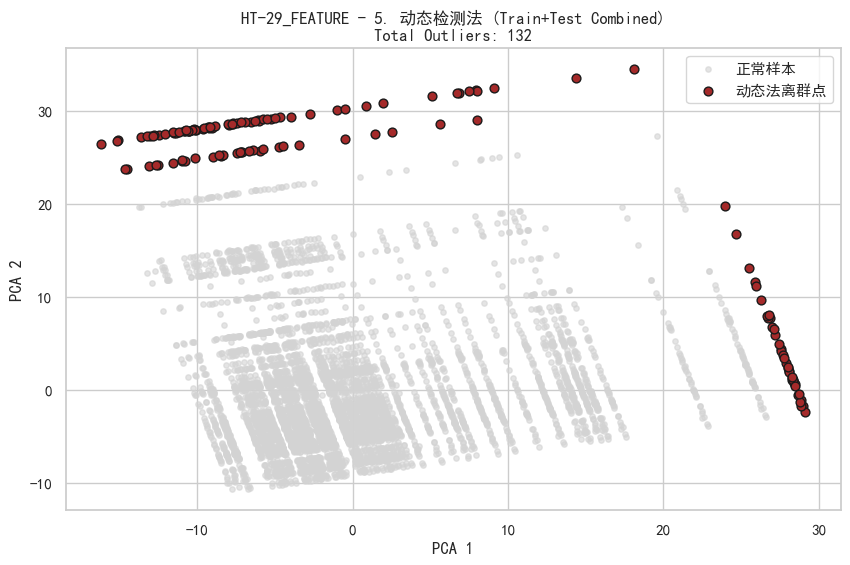

In [73]:
# 创建两个临时的 Series，索引分别是 idx_train 和 idx_test
s_train = pd.Series(is_outlier_train, index=idx_train)
s_test = pd.Series(is_outlier_test, index=idx_test)

# 合并并按索引重新排序 (恢复原始顺序)
s_final = pd.concat([s_train, s_test]).sort_index()

# 写入总表
outlier_flags['Dynamic'] = s_final

# 打印统计
num_dynamic_outliers = outlier_flags['Dynamic'].sum()
print(f"\n[完成] 动态检测结果已保存至 outlier_flags['Dynamic']")
print(f"   - 总离群点数量: {num_dynamic_outliers}")
print(f"   - 包含训练集中的离群簇样本 + 测试集中的已知/候选离群点")

# =========================================================
# 绘图验证 (Visual Check)
# =========================================================
plt.figure(figsize=(10, 6))
# 正常点
plt.scatter(X_pca[~outlier_flags['Dynamic'], 0], X_pca[~outlier_flags['Dynamic'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常样本')
# 异常点
plt.scatter(X_pca[outlier_flags['Dynamic'], 0], X_pca[outlier_flags['Dynamic'], 1], 
            c='brown', s=40, edgecolor='k', label='动态法离群点')

plt.title(f'{current_dataset_name} - 5. 动态检测法 (Train+Test Combined)\nTotal Outliers: {num_dynamic_outliers}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_5_Dynamic_Combined.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"验证图片已保存: {save_path}")

plt.show()

#### 模型更新与回溯

   [数据合并] 当前全量数据样本: 5279

   [模型更新后] 簇统计 (OF4 降序):
   ID | Size | OF4 Score | Status
   -----------------------------------
    8 |   38 | 42.464595  | OUTLIER
    2 |   64 | 39.801650  | OUTLIER
    7 |  402 | 20.005696  | OUTLIER
    0 |  509 | 18.395122  | Normal
    4 |  458 | 14.491961  | Normal
    6 |  379 | 14.378430  | Normal
    3 |  955 | 10.528142  | Normal
    5 |  964 | 10.264458  | Normal
    1 | 1510 | 9.866616  | Normal

   -> 更新后的离群簇 ID: [8, 2, 7]

[回溯分析] 模型更新后，有 372 个样本的判定结果发生了反转！
结果已保存至 outlier_flags['Dynamic_Updated']
图片已保存: output\HT-29_FEATURE_6_Dynamic_Updated.png


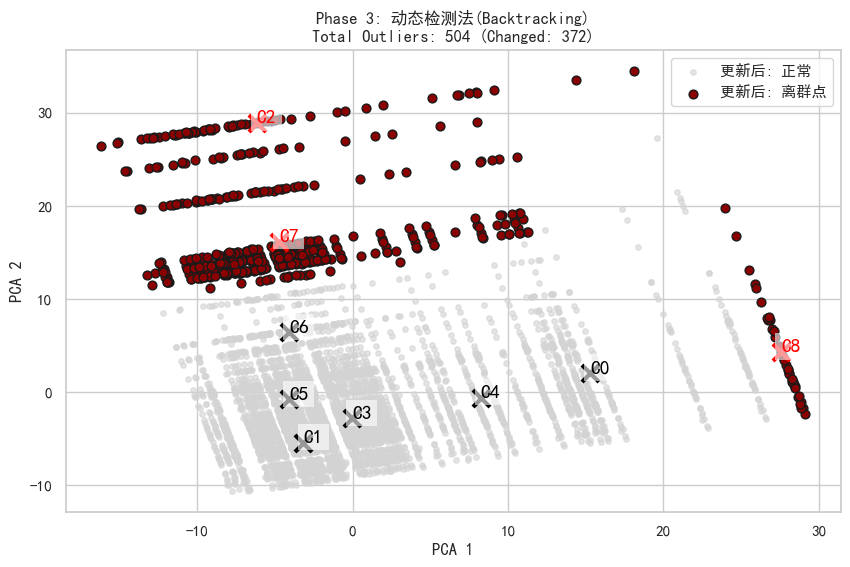

In [74]:
# 1. 合并数据 (训练集 + 测试集)
X_total = np.vstack([X_train, X_test])
idx_total = np.concatenate([idx_train, idx_test])

print(f"   [数据合并] 当前全量数据样本: {len(X_total)}")

# 2. 模型更新 (Simulate Incremental Update)
# 此时簇的形态(质心、大小)会发生漂移
kmeans_updated = KMeans(n_clusters=n_clusters_dynamic, random_state=42, n_init=10)
kmeans_updated.fit(X_total)

labels_updated = kmeans_updated.labels_
centroids_updated = kmeans_updated.cluster_centers_

# 3. 重新计算离群因子 OF4 (Re-calculate OF4)
# 计算新的簇大小和权重
sizes_updated = np.bincount(labels_updated, minlength=n_clusters_dynamic)
weights_updated = sizes_updated / len(X_total)

# 计算新的簇间距离矩阵
dist_matrix_updated = euclidean_distances(centroids_updated, centroids_updated)

# 计算新的 OF4 分数
of4_updated = np.dot(dist_matrix_updated, weights_updated)

# 4. 重新定义离群簇 (Re-define Outlier Clusters)
cluster_info_updated = []
for i in range(n_clusters_dynamic):
    cluster_info_updated.append({
        'id': i, 
        'size': sizes_updated[i], 
        'of4': of4_updated[i]
    })

# 按 OF4 降序排列
sorted_clusters_updated = sorted(cluster_info_updated, key=lambda x: x['of4'], reverse=True)

outlier_cluster_ids_updated = []
current_sum = 0

print(f"\n   [模型更新后] 簇统计 (OF4 降序):")
print(f"   ID | Size | OF4 Score | Status")
print(f"   {'-'*35}")

for c in sorted_clusters_updated:
    status = "Normal"
    # 筛选逻辑同前：累积比例 < epsilon
    if len(outlier_cluster_ids_updated) == 0 or (current_sum / len(X_total)) < epsilon:
        outlier_cluster_ids_updated.append(c['id'])
        current_sum += c['size']
        status = "OUTLIER"
    
    print(f"   {c['id']:2d} | {c['size']:4d} | {c['of4']:.6f}  | {status}")

print(f"\n   -> 更新后的离群簇 ID: {outlier_cluster_ids_updated}")

# 5. 回溯标记 (Backtracking Labeling)
# 所有样本(包括以前的训练集)都根据这个新模型重新打标
is_outlier_updated = np.isin(labels_updated, outlier_cluster_ids_updated)

# 6. 保存到总表 outlier_flags
# 创建 Series 并按索引对齐
s_updated = pd.Series(is_outlier_updated, index=idx_total).sort_index()
outlier_flags['Dynamic_Updated'] = s_updated

# ---------------------------------------------------------
# 对比与分析
# ---------------------------------------------------------
# 看看有多少点发生了变化
diff_count = (outlier_flags['Dynamic'] != outlier_flags['Dynamic_Updated']).sum()
print(f"\n[回溯分析] 模型更新后，有 {diff_count} 个样本的判定结果发生了反转！")
print(f"结果已保存至 outlier_flags['Dynamic_Updated']")

# ---------------------------------------------------------
# 绘图：更新后的全量视图
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# 画正常点
plt.scatter(X_pca[~outlier_flags['Dynamic_Updated'], 0], X_pca[~outlier_flags['Dynamic_Updated'], 1], 
            c='lightgray', s=15, alpha=0.6, label='更新后: 正常')

# 画异常点
plt.scatter(X_pca[outlier_flags['Dynamic_Updated'], 0], X_pca[outlier_flags['Dynamic_Updated'], 1], 
            c='darkred', s=40, edgecolor='k', label='更新后: 离群点')

# 标记新的簇中心
pca_model = None
if 'pca2' in locals(): pca_model = pca2
elif 'pca' in locals(): pca_model = pca

if pca_model:
    centers_2d = pca_model.transform(centroids_updated)
    for i, (cx, cy) in enumerate(centers_2d):
        color = 'red' if i in outlier_cluster_ids_updated else 'black'
        plt.scatter(cx, cy, marker='x', s=150, linewidths=3, c=color)
        plt.text(cx, cy, f"C{i}", color=color, weight='bold', fontsize=14,
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title(f'Phase 3: 动态检测法(Backtracking)\nTotal Outliers: {outlier_flags["Dynamic_Updated"].sum()} (Changed: {diff_count})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_6_Dynamic_Updated.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")

plt.show()

## Feature结果分析

【HT-29_FEATURE】 最终离群点分析报告
总样本数: 5279
被至少 1 种方法标记的样本数: 745
被至少 3 种方法标记的强离群点数: 177

>>> 正在导出 TOP 离群点详细信息...
               Drug_A     Drug_B  Synergy_Score  Votes  \
19       Methotrexate  Bleomycin          -35.0      4   
86           Busulfan  Bleomycin          -16.0      4   
186  6-Mercaptopurine  Bleomycin           16.0      4   
255  Nitrogen mustard  Bleomycin          -50.0      4   
334       Allopurinol  Bleomycin          -37.0      4   

                              Methods  
19   TOD,CBOD,Dynamic,Dynamic_Updated  
86   TOD,CBOD,Dynamic,Dynamic_Updated  
186  TOD,CBOD,Dynamic,Dynamic_Updated  
255  TOD,CBOD,Dynamic,Dynamic_Updated  
334  TOD,CBOD,Dynamic,Dynamic_Updated  

[完成] 详细名单已保存至: output\HT-29_FEATURE_Top_Outliers.csv
请使用 Excel 打开该文件，分析这些药物组合的化学结构特点。


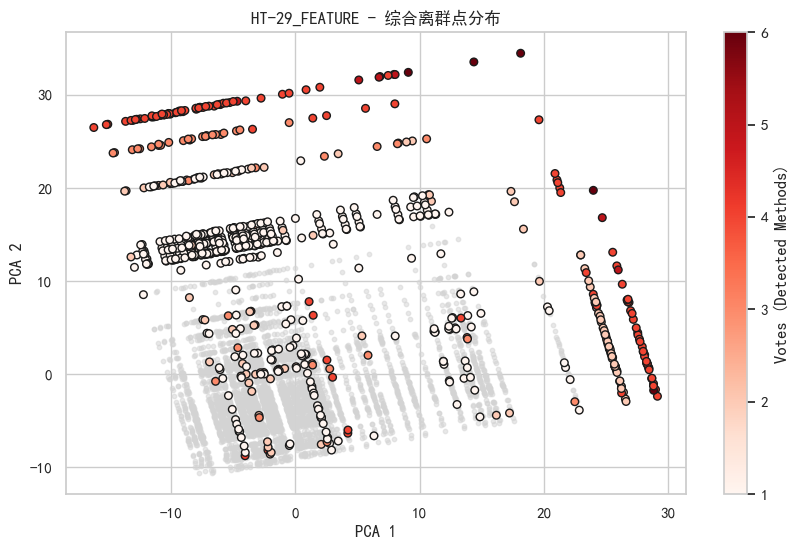

In [75]:
# 1. 计算"得票数"
outlier_flags['Votes'] = outlier_flags[['Stat', 'Dist', 'Density', 'TOD','CBOD','Dynamic','Dynamic_Updated']].sum(axis=1)

# 2. 筛选出高置信度离群点 (至少 3 种方法认为是异常)
high_conf_indices = outlier_flags[outlier_flags['Votes'] >= 3].index

print(f"{'='*40}")
print(f"【{current_dataset_name}】 最终离群点分析报告")
print(f"{'='*40}")
print(f"总样本数: {X_reduced.shape[0]}")
print(f"被至少 1 种方法标记的样本数: {(outlier_flags['Votes'] > 0).sum()}")
print(f"被至少 3 种方法标记的强离群点数: {len(high_conf_indices)}")

if len(high_conf_indices) > 0:
    print(f"\n>>> 正在导出 TOP 离群点详细信息...")
    
    # 提取这些离群点的 药物名、结构、SynergyScore
    # 注意：这里用 loc 根据索引去 df_smiles_current 里查信息
    top_outliers_info = df_smiles_current.loc[high_conf_indices, ['Drug_A', 'Drug_B']].copy()
    
    # 把特征表里的 Synergy 和 Class_Label 也拼过来
    # 假设 Synergy 是第 416 列 (iloc 416), Label 是 417
    # 也可以直接用列名如果列名还在的话
    top_outliers_info['Synergy_Score'] = df_current.loc[high_conf_indices].iloc[:, 416]
    top_outliers_info['Votes'] = outlier_flags.loc[high_conf_indices, 'Votes']
    top_outliers_info['Methods'] = outlier_flags.loc[high_conf_indices, ['Stat', 'Dist', 'Density', 'TOD','CBOD','Dynamic','Dynamic_Updated']].apply(
        lambda x: ','.join(x.index[x]), axis=1
    )

    # 显示前几行
    print(top_outliers_info.head())
    
    # 保存到 CSV
    csv_filename = f"{current_dataset_name}_Top_Outliers.csv"
    csv_path = os.path.join(OUTPUT_DIR, csv_filename)
    top_outliers_info.to_csv(csv_path)
    print(f"\n[完成] 详细名单已保存至: {csv_path}")
    print("请使用 Excel 打开该文件，分析这些药物组合的化学结构特点。")

else:
    print("\n没有发现 Votes >= 3 的强离群点。说明不同算法对异常的定义在该数据集中差异较大。")
    
# 3. 最终可视化 (按得票数染色)
plt.figure(figsize=(10, 6))
mask_normal = outlier_flags['Votes'] == 0
plt.scatter(X_pca[mask_normal, 0], X_pca[mask_normal, 1], c='lightgray', s=10, alpha=0.5, label='Normal')

mask_abnormal = outlier_flags['Votes'] > 0
sc = plt.scatter(X_pca[mask_abnormal, 0], X_pca[mask_abnormal, 1], 
                 c=outlier_flags.loc[mask_abnormal, 'Votes'], 
                 cmap='Reds', s=30, edgecolor='k', label='Outliers')

plt.colorbar(sc, label='Votes (Detected Methods)')
plt.title(f'{current_dataset_name} - 综合离群点分布')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_7_Final_Summary.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()


# 基于SMILE结构的离群点检测

## 计算摩根指纹

In [76]:
def get_fingerprint(smiles, n_bits=1024):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return np.zeros(n_bits)
        # 半径为2，类似 ECFP4
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    except:
        return np.zeros(n_bits)

fp_list = []
# 假设 df_smiles 已经加载 (如果没加载请确保先读取 dataset_smiles.csv)
for idx, row in df_smiles_current.iterrows():
    fp_a = get_fingerprint(row['SMILES_A'])
    fp_b = get_fingerprint(row['SMILES_B'])
    # 拼接两个药物的指纹
    fp_list.append(np.concatenate([fp_a, fp_b]))

X_fingerprints = np.array(fp_list)
print(f"指纹矩阵构建完成，维度: {X_fingerprints.shape}")

# =========================================================
# 2. PCA 降维 (SMILES Space)
# =========================================================
print("正在进行 PCA 降维 (SMILES Space)...")

# 降维到95%方差
pca_calc = PCA(n_components=0.95)
X_smiles_reduced = pca_calc.fit_transform(X_fingerprints)
print(f"降维完成，维度: {X_smiles_reduced.shape}")

# 降维到 2 维用于画图
pca_vis = PCA(n_components=2)
X_smiles_pca = pca_vis.fit_transform(X_fingerprints)

# 初始化结果表
outlier_flags_smile = pd.DataFrame(index=df_smiles_current.index)

指纹矩阵构建完成，维度: (5279, 2048)
正在进行 PCA 降维 (SMILES Space)...
降维完成，维度: (5279, 126)


## 1.基于统计的离群点分析

正在运行统计法检测 (SMILES)...
图片已保存: output\HT-29_FEATURE_1_Statistical.png


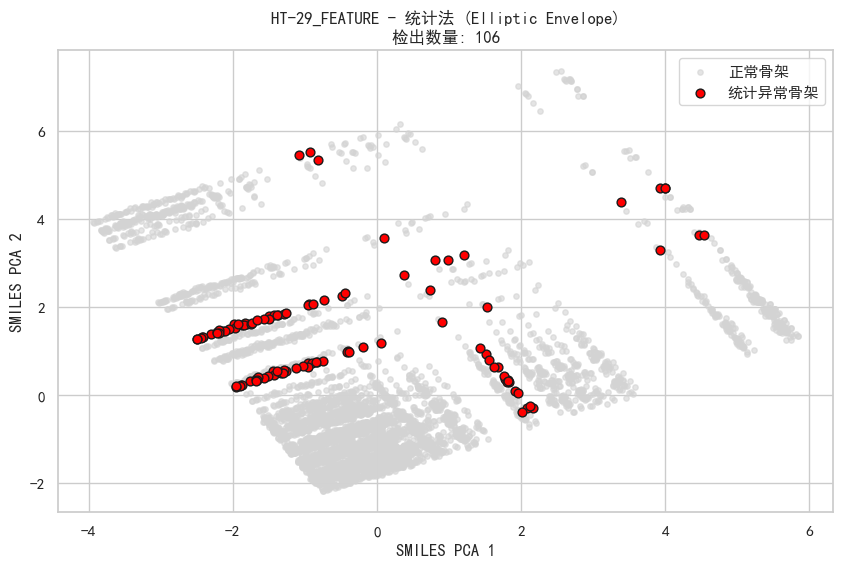

In [77]:
print(f"正在运行统计法检测 (SMILES)...")
contamination = 0.02

ee = EllipticEnvelope(contamination=contamination, support_fraction=0.9, random_state=42)
y_pred_stat = ee.fit_predict(X_smiles_reduced) 

outlier_flags_smile['Stat'] = (y_pred_stat == -1)

# 绘图
plt.figure(figsize=(10, 6))
plt.scatter(X_smiles_pca[~outlier_flags_smile['Stat'], 0], X_smiles_pca[~outlier_flags_smile['Stat'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常骨架')
plt.scatter(X_smiles_pca[outlier_flags_smile['Stat'], 0], X_smiles_pca[outlier_flags_smile['Stat'], 1], 
            c='red', s=40, edgecolor='k', label='统计异常骨架')

plt.title(f'{current_dataset_name} - 统计法 (Elliptic Envelope)\n检出数量: {outlier_flags_smile["Stat"].sum()}')
plt.xlabel('SMILES PCA 1')
plt.ylabel('SMILES PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_1_Statistical.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")
plt.show()

## 2.基于距离的离群点分析

正在运行距离法检测 (SMILES)...
图片已保存: output\HT-29_FEATURE_2_Distance.png


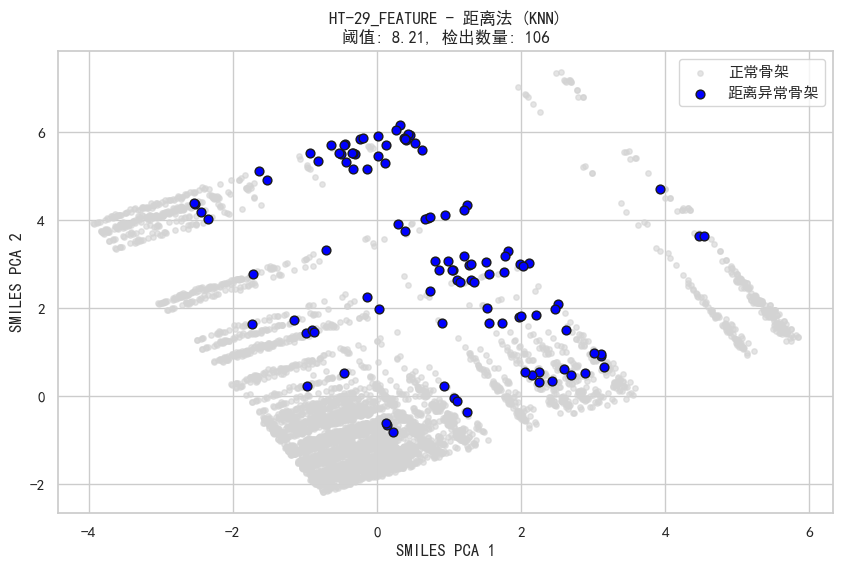

In [78]:
print(f"正在运行距离法检测 (SMILES)...")
k = 5
knn = NearestNeighbors(n_neighbors=k) # 这里对PCA后的数据用欧氏距离近似
knn.fit(X_smiles_reduced)

distances, _ = knn.kneighbors(X_smiles_reduced)
kth_dist = distances[:, -1]
threshold_dist = np.percentile(kth_dist, 100 * (1 - contamination))

outlier_flags_smile['Dist'] = kth_dist > threshold_dist

# 绘图
plt.figure(figsize=(10, 6))
plt.scatter(X_smiles_pca[~outlier_flags_smile['Dist'], 0], X_smiles_pca[~outlier_flags_smile['Dist'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常骨架')
plt.scatter(X_smiles_pca[outlier_flags_smile['Dist'], 0], X_smiles_pca[outlier_flags_smile['Dist'], 1], 
            c='blue', s=40, edgecolor='k', label='距离异常骨架')

plt.title(f'{current_dataset_name} - 距离法 (KNN)\n阈值: {threshold_dist:.2f}, 检出数量: {outlier_flags_smile["Dist"].sum()}')
plt.xlabel('SMILES PCA 1')
plt.ylabel('SMILES PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_2_Distance.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")
plt.show()

## 3.基于密度的离群点分析

正在运行密度法检测 (SMILES)...
图片已保存: output\HT-29_FEATURE_3_Density.png


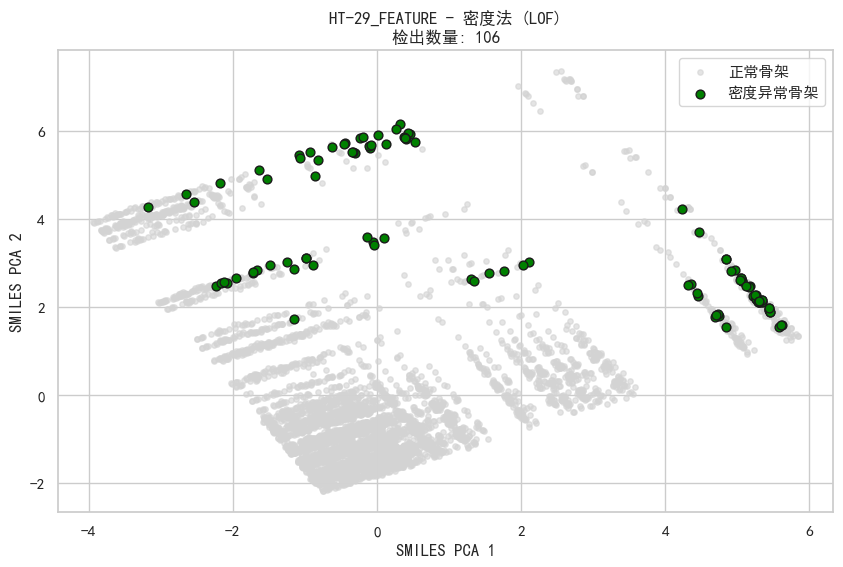

In [79]:
print(f"正在运行密度法检测 (SMILES)...")
lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
y_pred_lof = lof.fit_predict(X_smiles_reduced)

outlier_flags_smile['Density'] = (y_pred_lof == -1)

# 绘图
plt.figure(figsize=(10, 6))
plt.scatter(X_smiles_pca[~outlier_flags_smile['Density'], 0], X_smiles_pca[~outlier_flags_smile['Density'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常骨架')
plt.scatter(X_smiles_pca[outlier_flags_smile['Density'], 0], X_smiles_pca[outlier_flags_smile['Density'], 1], 
            c='green', s=40, edgecolor='k', label='密度异常骨架')

plt.title(f'{current_dataset_name} - 密度法 (LOF)\n检出数量: {outlier_flags_smile["Density"].sum()}')
plt.xlabel('SMILES PCA 1')
plt.ylabel('SMILES PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_3_Density.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")
plt.show()

## 4.基于聚类的离群点分析
### 4.1两阶段离群点挖掘方法（TOD）


正在运行 TOD 方法（SMILES）...
   [TOD结构] Ave_OF: 9.0561, Dev_OF: 1.4480, Beta: 2
   [TOD结构] 阈值: 11.9522
图片已保存: output\HT-29_FEATURE_4_TOD.png


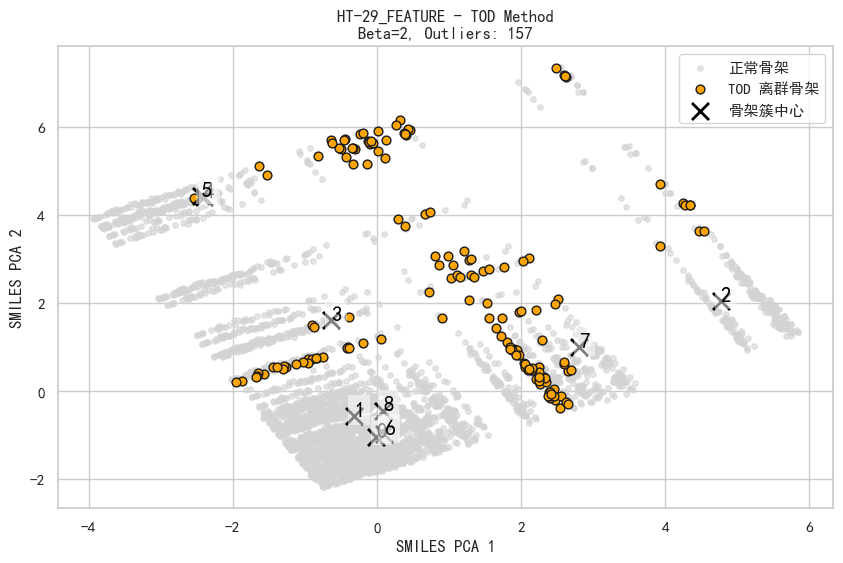

In [80]:
print(f"\n正在运行 TOD 方法（SMILES）...")

# 参数设置
n_clusters = 9
beta = 2  

# 第一阶段：聚类
# 使用 K-Means 对降维后的指纹数据进行聚类
kmeans_struct = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_struct.fit(X_smiles_reduced)

# 第二阶段：计算离群因子 OF3 (Phase 2: Calculate Outlier Factor)

# 1. 计算距离 d(p, Cj)
dist_matrix = kmeans_struct.transform(X_smiles_reduced)

# 2. 计算权重 |Cj| / |D|
labels = kmeans_struct.labels_
cluster_sizes = np.bincount(labels, minlength=n_clusters)
total_samples = len(X_smiles_reduced)
cluster_weights = cluster_sizes / total_samples

# 3. 计算 OF3(p): 加权平均距离
of3_scores = np.dot(dist_matrix, cluster_weights)

# ---------------------------------------------------------
# 第三阶段：判定 (Thresholding)
# ---------------------------------------------------------
ave_of = np.mean(of3_scores)
dev_of = np.std(of3_scores)
threshold_tod = ave_of + beta * dev_of

# 记录结果
outlier_flags_smile['TOD'] = of3_scores >= threshold_tod

print(f"   [TOD结构] Ave_OF: {ave_of:.4f}, Dev_OF: {dev_of:.4f}, Beta: {beta}")
print(f"   [TOD结构] 阈值: {threshold_tod:.4f}")

# ---------------------------------------------------------
# 绘图 
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# 1. 画正常骨架
plt.scatter(X_smiles_pca[~outlier_flags_smile['TOD'], 0], X_smiles_pca[~outlier_flags_smile['TOD'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常骨架')

# 2. 画异常骨架
plt.scatter(X_smiles_pca[outlier_flags_smile['TOD'], 0], X_smiles_pca[outlier_flags_smile['TOD'], 1], 
            c='orange', s=40, edgecolor='k', label='TOD 离群骨架')

# 3. 【修复】绘制簇中心
# 不再使用 pca_vis.transform，而是直接计算 2D 点的均值
try:
    # 遍历每个簇 (0 到 8)
    for i in range(n_clusters):
        # 找到属于簇 i 的所有点在 2D 图上的坐标
        # labels 来自于 kmeans_struct.labels_
        points_in_cluster_2d = X_smiles_pca[labels == i]
        
        if len(points_in_cluster_2d) > 0:
            # 计算这些点的平均值，这就是簇中心在图上的位置！
            cx, cy = np.mean(points_in_cluster_2d, axis=0)
            
            # 绘制中心点 (黑色 X)
            plt.scatter(cx, cy, marker='x', s=150, linewidths=2, color='black')
            
            # 标上数字 ID
            plt.text(cx, cy, str(i), fontsize=15, color='black', weight='bold',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
            
    # 为了图例显示正常，画一个假的中心点进图例
    plt.scatter([], [], marker='x', s=150, linewidths=2, color='black', label='骨架簇中心')

except Exception as e:
    print(f"警告: 绘制簇中心时发生错误: {e}")

plt.title(f'{current_dataset_name} - TOD Method\nBeta={beta}, Outliers: {outlier_flags_smile["TOD"].sum()}')
plt.xlabel('SMILES PCA 1')
plt.ylabel('SMILES PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_4_TOD.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")
plt.show()


### 4.2基于聚类的离群挖掘方法 CBOD


正在运行 CBOD 方法（SMILES)...
   [复用] 簇数量 K=9
   [CBOD] 结构簇离群因子统计:
   Rank | ID | Size | OF4 Score | Cumulative %
   --------------------------------------------------
      1 |  3 |   95 | 9.522634  | 1.80%
      2 |  5 |  194 | 8.604264  | 5.47%
图片已保存: output\HT-29_FEATURE_4_CBOD.png


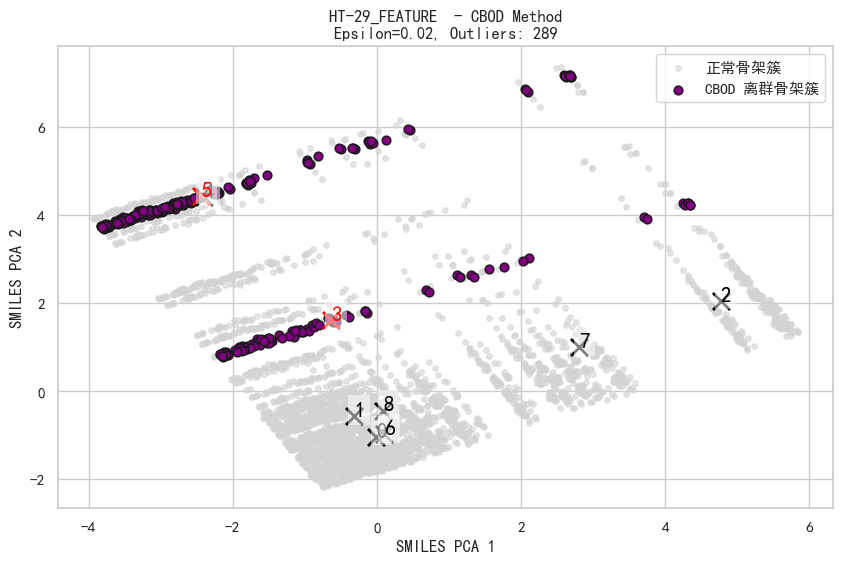


[完成] TOD 与 CBOD 结构空间分析结束。


In [81]:
print(f"\n正在运行 CBOD 方法（SMILES)...")

epsilon = 0.02 

# =========================================================
# 1. 复用聚类信息
# =========================================================
centroids = kmeans_struct.cluster_centers_
print(f"   [复用] 簇数量 K={len(centroids)}")

# =========================================================
# 2. 计算 OF4
# =========================================================
# 计算簇中心之间的距离矩阵
centroid_dist_matrix = euclidean_distances(centroids, centroids)

# 计算 OF4
of4_scores_cbod = np.dot(centroid_dist_matrix, cluster_weights)

# 整理
cbod_stats = []
for i in range(len(centroids)):
    cbod_stats.append({
        'cluster_id': i,
        'size': cluster_sizes[i],
        'of4': of4_scores_cbod[i]
    })

# =========================================================
# 3. 排序与判定
# =========================================================
sorted_cbod = sorted(cbod_stats, key=lambda x: x['of4'], reverse=True)

current_sum = 0
outlier_cluster_ids = []

print(f"   [CBOD] 结构簇离群因子统计:")
print(f"   Rank | ID | Size | OF4 Score | Cumulative %")
print(f"   {'-'*50}")

for rank, c in enumerate(sorted_cbod):
    current_sum += c['size']
    cumulative_ratio = current_sum / total_samples
    
    print(f"   {rank+1:4d} | {c['cluster_id']:2d} | {c['size']:4d} | {c['of4']:.6f}  | {cumulative_ratio*100:.2f}%")
    
    if len(outlier_cluster_ids) == 0 or (current_sum - c['size']) / total_samples < epsilon:
         outlier_cluster_ids.append(c['cluster_id'])
    
    if cumulative_ratio >= epsilon:
        break

# 标记样本
outlier_flags_smile['CBOD'] = np.isin(labels, outlier_cluster_ids)

# =========================================================
# 4. 绘图 (CBOD Structure)
# =========================================================
plt.figure(figsize=(10, 6))

# 1. 画正常骨架
plt.scatter(X_smiles_pca[~outlier_flags_smile['CBOD'], 0], X_smiles_pca[~outlier_flags_smile['CBOD'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常骨架簇')

# 2. 画离群骨架簇
plt.scatter(X_smiles_pca[outlier_flags_smile['CBOD'], 0], X_smiles_pca[outlier_flags_smile['CBOD'], 1], 
            c='purple', s=40, edgecolor='k', label='CBOD 离群骨架簇')

# 3. 标记中心 (使用 2D 点的均值计算，避开维度报错)
try:
    # 这里的 labels 是 K-Means 的聚类标签
    # X_smiles_pca 是 2D 坐标
    
    # 遍历每个簇
    for i in range(len(centroids)):
        # 找到属于簇 i 的所有点在图上的 2D 坐标
        points_in_cluster = X_smiles_pca[labels == i]
        
        if len(points_in_cluster) > 0:
            # 计算这些点的平均值，这就是簇中心在图上的位置！
            cx, cy = np.mean(points_in_cluster, axis=0)
            
            # 颜色逻辑
            text_color = 'red' if i in outlier_cluster_ids else 'black'
            font_weight = 'bold' if i in outlier_cluster_ids else 'normal'
            
            # 绘制
            plt.scatter(cx, cy, marker='x', s=150, linewidths=2, color=text_color)
            plt.text(cx, cy, str(i), fontsize=15, color=text_color, weight=font_weight,
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
                     
except Exception as e:
    print(f"警告: 绘制簇中心时发生错误: {e}")

plt.title(f'{current_dataset_name}  - CBOD Method\nEpsilon={epsilon}, Outliers: {outlier_flags_smile["CBOD"].sum()}')
plt.xlabel('SMILES PCA 1')
plt.ylabel('SMILES PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_4_CBOD.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")
plt.show()

print("\n[完成] TOD 与 CBOD 结构空间分析结束。")

## 5.基于聚类的动态数据的离群点检测

### 建立初始模型

   [数据切分] 训练集: 4223, 测试集: 1056
   [模型定义] 结构离群簇 ID: [2]
   [结果] 动态检测离群结构数: 113


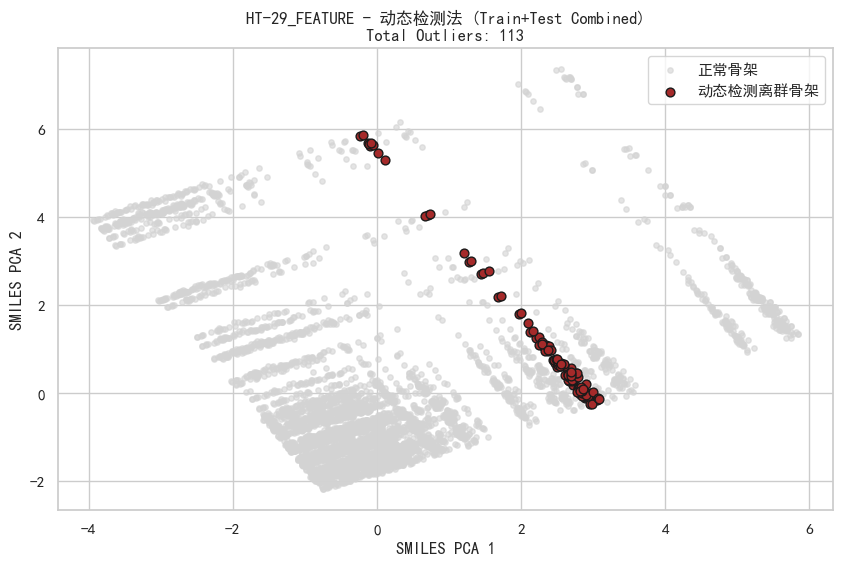

In [82]:
# 参数设置
n_clusters_dynamic = 9  # 保持与 TOD/CBOD 一致
epsilon = 0.02 

# 带索引切分数据
# 使用 X_smiles_reduced
# idx_train/test 用于记录原始行号，以便最后填回 outlier_flags_smile
X_train, X_test, idx_train, idx_test = train_test_split(
    X_smiles_reduced, df_smiles_current.index, test_size=0.2, random_state=42
)

print(f"   [数据切分] 训练集: {len(X_train)}, 测试集: {len(X_test)}")


# Phase 1: 模型建立

kmeans_dyn = KMeans(n_clusters=n_clusters_dynamic, random_state=42, n_init=10)
kmeans_dyn.fit(X_train)
labels_train = kmeans_dyn.labels_
centroids = kmeans_dyn.cluster_centers_

# --- 确定离群簇 (CBOD逻辑) ---
train_sizes = np.bincount(labels_train, minlength=n_clusters_dynamic)
train_weights = train_sizes / len(X_train)
centroid_dist = euclidean_distances(centroids, centroids)
of4_scores = np.dot(centroid_dist, train_weights)

# 排序并筛选离群簇
cluster_info = [{'id': i, 'size': s, 'of4': o} for i, s, o in zip(range(n_clusters_dynamic), train_sizes, of4_scores)]
sorted_clusters = sorted(cluster_info, key=lambda x: x['of4'], reverse=True)

outlier_cluster_ids = []
curr_sum = 0
for c in sorted_clusters:
    # 逻辑：至少选一个，且累积比例 < epsilon 时继续选
    if len(outlier_cluster_ids) == 0 or (curr_sum / len(X_train)) < epsilon:
        outlier_cluster_ids.append(c['id'])
        curr_sum += c['size']
    else:
        break
        
print(f"   [模型定义] 结构离群簇 ID: {outlier_cluster_ids}")

# --- 确定簇半径 (Radius) ---
cluster_radii = np.zeros(n_clusters_dynamic)
train_dists = kmeans_dyn.transform(X_train)
for i in range(n_clusters_dynamic):
    dists = train_dists[labels_train == i, i]
    if len(dists) > 0:
        cluster_radii[i] = np.max(dists) # 定义半径为簇内最大距离


# Phase 2: 模型评估 (INN)

# --- A. 处理训练集结果 ---
is_outlier_train = np.isin(labels_train, outlier_cluster_ids)

# --- B. 处理测试集结果 ---
test_dists = kmeans_dyn.transform(X_test)
is_outlier_test = []

for i in range(len(X_test)):
    # 找到最近簇
    nearest_id = np.argmin(test_dists[i])
    dist = test_dists[i][nearest_id]
    
    # INN 判定逻辑
    if dist <= cluster_radii[nearest_id]:
        # 半径内：继承簇的性质
        if nearest_id in outlier_cluster_ids:
            is_outlier_test.append(True) # 已知离群结构
        else:
            is_outlier_test.append(False) # 正常结构
    else:
        # 半径外：候选离群结构 (新颖骨架)
        is_outlier_test.append(True)

is_outlier_test = np.array(is_outlier_test)

# ---------------------------------------------------------
# 保存到 outlier_flags_smile
# ---------------------------------------------------------
s_train = pd.Series(is_outlier_train, index=idx_train)
s_test = pd.Series(is_outlier_test, index=idx_test)
s_final = pd.concat([s_train, s_test]).sort_index()

outlier_flags_smile['Dynamic'] = s_final

print(f"   [结果] 动态检测离群结构数: {outlier_flags_smile['Dynamic'].sum()}")

# 绘图验证
plt.figure(figsize=(10, 6))
# 正常骨架
plt.scatter(X_smiles_pca[~outlier_flags_smile['Dynamic'], 0], X_smiles_pca[~outlier_flags_smile['Dynamic'], 1], 
            c='lightgray', s=15, alpha=0.6, label='正常骨架')
# 离群骨架
plt.scatter(X_smiles_pca[outlier_flags_smile['Dynamic'], 0], X_smiles_pca[outlier_flags_smile['Dynamic'], 1], 
            c='brown', s=40, edgecolor='k', label='动态检测离群骨架')

plt.title(f'{current_dataset_name} - 动态检测法 (Train+Test Combined)\nTotal Outliers: {outlier_flags_smile["Dynamic"].sum()}')
plt.xlabel('SMILES PCA 1')
plt.ylabel('SMILES PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_5_Dynamic_Combined.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

### 模型更新与回溯检查


--- Phase 3: 结构空间模型更新 (Model Update) ---
   [更新后] 离群簇 ID: [7]
   [回溯分析] 判定反转样本数: 0
图片已保存: output\HT-29_FEATURE_6_Dynamic_Updated.png


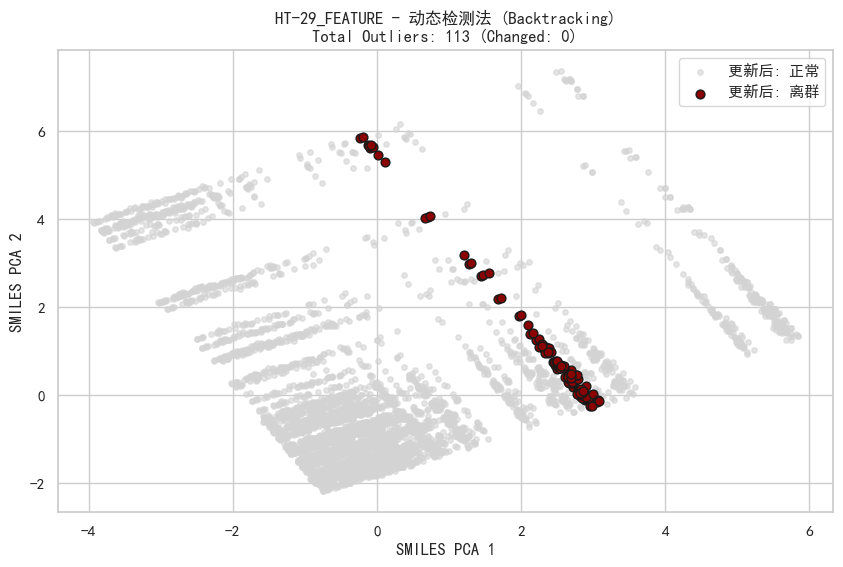

In [83]:
# Phase 3: 模型更新与回溯
print(f"\n--- Phase 3: 结构空间模型更新 (Model Update) ---")

# 1. 合并数据
X_total = np.vstack([X_train, X_test])
idx_total = np.concatenate([idx_train, idx_test])

# 2. 模型更新 (在全量指纹数据上重新聚类)
kmeans_updated = KMeans(n_clusters=n_clusters_dynamic, random_state=42, n_init=10)
kmeans_updated.fit(X_total)

labels_updated = kmeans_updated.labels_
centroids_updated = kmeans_updated.cluster_centers_

# 3. 重新计算 OF4
sizes_updated = np.bincount(labels_updated, minlength=n_clusters_dynamic)
weights_updated = sizes_updated / len(X_total)
dist_matrix_updated = euclidean_distances(centroids_updated, centroids_updated)
of4_updated = np.dot(dist_matrix_updated, weights_updated)

# 4. 重新定义离群簇
cluster_info_updated = []
for i in range(n_clusters_dynamic):
    cluster_info_updated.append({'id': i, 'size': sizes_updated[i], 'of4': of4_updated[i]})

sorted_clusters_updated = sorted(cluster_info_updated, key=lambda x: x['of4'], reverse=True)

outlier_cluster_ids_updated = []
curr_sum = 0
for c in sorted_clusters_updated:
    if len(outlier_cluster_ids_updated) == 0 or (curr_sum / len(X_total)) < epsilon:
        outlier_cluster_ids_updated.append(c['id'])
        curr_sum += c['size']
    else:
        break
        
print(f"   [更新后] 离群簇 ID: {outlier_cluster_ids_updated}")

# 5. 回溯标记
is_outlier_updated = np.isin(labels_updated, outlier_cluster_ids_updated)

# 6. 保存到 outlier_flags_smile
s_updated = pd.Series(is_outlier_updated, index=idx_total).sort_index()
outlier_flags_smile['Dynamic_Updated'] = s_updated

# 对比变化
diff_count = (outlier_flags_smile['Dynamic'] != outlier_flags_smile['Dynamic_Updated']).sum()
print(f"   [回溯分析] 判定反转样本数: {diff_count}")

# 绘图：更新后的全量视图
plt.figure(figsize=(10, 6))

# 画正常骨架
plt.scatter(X_smiles_pca[~outlier_flags_smile['Dynamic_Updated'], 0], X_smiles_pca[~outlier_flags_smile['Dynamic_Updated'], 1], 
            c='lightgray', s=15, alpha=0.6, label='更新后: 正常')

# 画离群骨架
plt.scatter(X_smiles_pca[outlier_flags_smile['Dynamic_Updated'], 0], X_smiles_pca[outlier_flags_smile['Dynamic_Updated'], 1], 
            c='darkred', s=40, edgecolor='k', label='更新后: 离群')

plt.title(f'{current_dataset_name} - 动态检测法 (Backtracking)\nTotal Outliers: {outlier_flags_smile["Dynamic_Updated"].sum()} (Changed: {diff_count})')
plt.xlabel('SMILES PCA 1')
plt.ylabel('SMILES PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_6_Dynamic_Updated.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path}")
plt.show()

## SMILE结果分析


==================== 最终汇总：SMILES 结构空间离群点分析报告 ====================
参与结构投票的方法: ['Stat', 'Dist', 'Density', 'TOD', 'CBOD', 'Dynamic', 'Dynamic_Updated']
----------------------------------------
总样本数: 5279
被至少 1 种方法标记为结构异常: 675
被至少 3 种方法标记的【强结构离群点】: 62
----------------------------------------

>>> 正在导出 TOP 结构离群点详细信息...
          Drug_A       Drug_B  Synergy_Score  Votes  \
4621  Everolimus    Rapamycin          -57.0      6   
2706   Rapamycin  Mithramycin           -7.0      5   
4651  Everolimus  Cabazitaxel           12.0      5   
2714   Rapamycin  Vincristine          -27.0      5   
4626  Everolimus  Vinorelbine           30.0      5   

                                                Methods  
4621  Dist, Density, TOD, CBOD, Dynamic, Dynamic_Upd...  
2706          Stat, Dist, TOD, Dynamic, Dynamic_Updated  
4651       Dist, Density, TOD, Dynamic, Dynamic_Updated  
2714       Density, TOD, CBOD, Dynamic, Dynamic_Updated  
4626       Density, TOD, CBOD, Dynamic, Dynamic_Updated  

[完

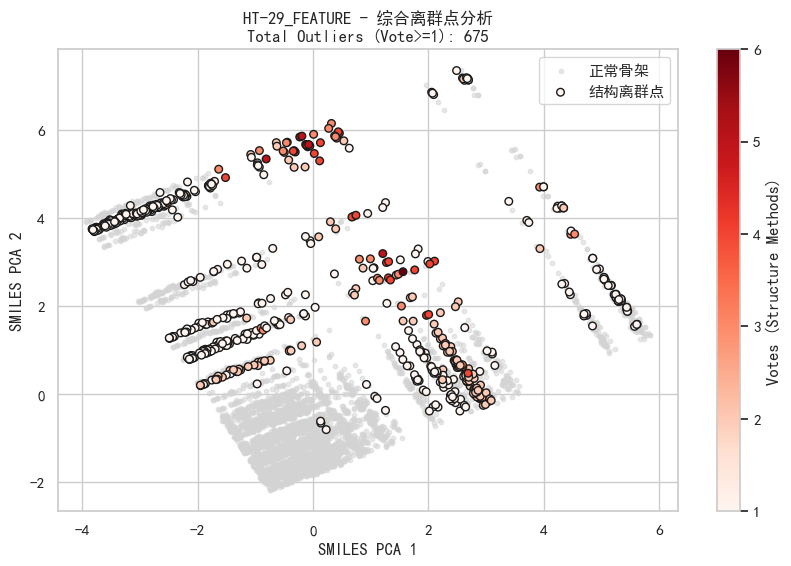

In [84]:
print(f"\n{'='*20} 最终汇总：SMILES 结构空间离群点分析报告 {'='*20}")

# 1. 准备变量
# 确保使用正确的 SMILES DataFrame
if 'df_smiles_current' in locals():
    target_df = locals().get('df_smiles_current')
elif 'df_smiles' in locals():
    target_df = locals().get('df_smiles')
else:
    print("警告: 找不到原始 SMILES 数据表，导出信息可能不完整。")
    target_df = pd.DataFrame(index=outlier_flags_smile.index)

# 2. 计算"得票数" (Votes) - 使用 outlier_flags_smile
# 统计一个样本在结构上被多少种算法判定为异常
all_struct_methods = ['Stat', 'Dist', 'Density', 'TOD', 'CBOD', 'Dynamic', 'Dynamic_Updated']
# 只计算实际存在的列
existing_methods = [col for col in all_struct_methods if col in outlier_flags_smile.columns]

print(f"参与结构投票的方法: {existing_methods}")
outlier_flags_smile['Votes'] = outlier_flags_smile[existing_methods].sum(axis=1)

# 3. 筛选高置信度离群点 (至少 3 种方法认为是结构异常)
high_conf_indices = outlier_flags_smile[outlier_flags_smile['Votes'] >= 3].index

print(f"----------------------------------------")
print(f"总样本数: {len(outlier_flags_smile)}")
print(f"被至少 1 种方法标记为结构异常: {(outlier_flags_smile['Votes'] > 0).sum()}")
print(f"被至少 3 种方法标记的【强结构离群点】: {len(high_conf_indices)}")
print(f"----------------------------------------")

if len(high_conf_indices) > 0:
    print(f"\n>>> 正在导出 TOP 结构离群点详细信息...")
    
    # 提取信息: 药名 + SMILES (可选) + 得票数
    top_struct_outliers = target_df.loc[high_conf_indices, ['Drug_A', 'Drug_B']].copy()
    
    # 添加投票详情
    top_struct_outliers['Synergy_Score'] = df_smiles_current.loc[high_conf_indices].iloc[:, 4]
    top_struct_outliers['Votes'] = outlier_flags_smile.loc[high_conf_indices, 'Votes']
    top_struct_outliers['Methods'] = outlier_flags_smile.loc[high_conf_indices, existing_methods].apply(
        lambda x: ', '.join(x.index[x]), axis=1
    )

    # 按得票数降序排列
    top_struct_outliers = top_struct_outliers.sort_values('Votes', ascending=False)

    # 显示前 5 行
    print(top_struct_outliers.head())
    
    # 保存到 CSV
    csv_filename = f"{current_dataset_name}_Top_Outliers.csv"
    csv_path = os.path.join(OUTPUT_DIR, csv_filename)
    top_struct_outliers.to_csv(csv_path)
    print(f"\n[完成] 结构离群名单已保存至: {csv_path}")
    print("请检查这些药物是否具有独特的大环、长链或稀有杂环结构。")

else:
    print("\n没有发现 Votes >= 3 的强结构离群点。")
    
# 4. 最终可视化 (SMILES Space Venn Visualization)
# 注意：这里必须使用 X_smiles_pca (结构空间的 PCA 投影)
plt.figure(figsize=(10, 6))

# 画正常骨架
mask_normal = outlier_flags_smile['Votes'] == 0
plt.scatter(X_smiles_pca[mask_normal, 0], X_smiles_pca[mask_normal, 1], 
            c='lightgray', s=10, alpha=0.5, label='正常骨架')

# 画异常骨架 (颜色越深，得票越多)
mask_abnormal = outlier_flags_smile['Votes'] > 0
if mask_abnormal.sum() > 0:
    sc = plt.scatter(X_smiles_pca[mask_abnormal, 0], X_smiles_pca[mask_abnormal, 1], 
                     c=outlier_flags_smile.loc[mask_abnormal, 'Votes'], 
                     cmap='Reds', s=30, edgecolor='k', label='结构离群点')
    plt.colorbar(sc, label='Votes (Structure Methods)')

plt.title(f'{current_dataset_name} - 综合离群点分析\nTotal Outliers (Vote>=1): {mask_abnormal.sum()}')
plt.xlabel('SMILES PCA 1')
plt.ylabel('SMILES PCA 2')
plt.legend()

save_path = os.path.join(OUTPUT_DIR, f"{current_dataset_name}_7_Final_Summary.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"汇总图表已保存: {save_path}")

plt.show()

# Feature性质空间的SMILE结构空间的离群点对比

分析阈值: Votes >= 3
1. Feature 空间离群总数: 177
2. SMILES 空间离群总数:  62
------------------------------
【重叠】双重离群、: 17
【差异】仅特征离群: 160
【差异】仅结构离群: 45
集合相似度 (Jaccard Index): 0.0766


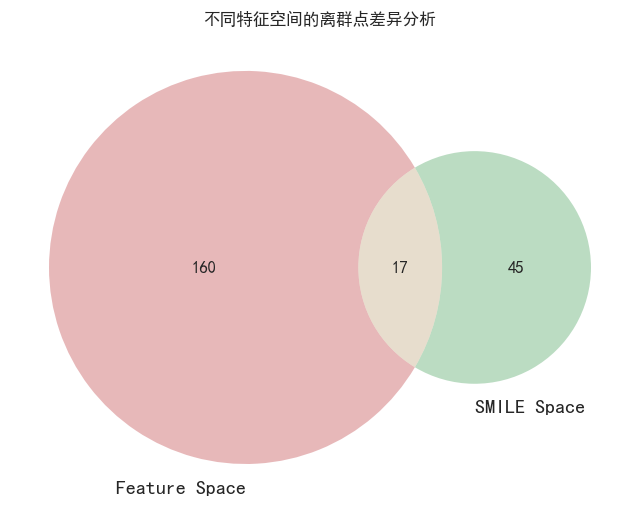

In [85]:
# 阈值：至少被 3 种算法判定为异常
THRESHOLD_VOTE = 3

# 特征空间 (Feature Space) 的离群点索引
# 确保 Votes 列存在
if 'Votes' not in outlier_flags.columns:
    cols = [c for c in ['Stat', 'Dist', 'Density', 'TOD', 'CBOD', 'Dynamic', 'Dynamic_Updated'] if c in outlier_flags.columns]
    outlier_flags['Votes'] = outlier_flags[cols].sum(axis=1)
idx_feat = set(outlier_flags[outlier_flags['Votes'] >= THRESHOLD_VOTE].index)

# 结构空间 (SMILES Space) 的离群点索引
if 'Votes' not in outlier_flags_smile.columns:
    cols = [c for c in ['Stat', 'Dist', 'Density', 'TOD', 'CBOD', 'Dynamic', 'Dynamic_Updated'] if c in outlier_flags_smile.columns]
    outlier_flags_smile['Votes'] = outlier_flags_smile[cols].sum(axis=1)
idx_smile = set(outlier_flags_smile[outlier_flags_smile['Votes'] >= THRESHOLD_VOTE].index)

# A. 交集
intersection = idx_feat.intersection(idx_smile)

# B. 仅特征离群
only_feat = idx_feat - idx_smile

# C. 仅结构离群
only_smile = idx_smile - idx_feat

print(f"分析阈值: Votes >= {THRESHOLD_VOTE}")
print(f"1. Feature 空间离群总数: {len(idx_feat)}")
print(f"2. SMILES 空间离群总数:  {len(idx_smile)}")
print(f"-" * 30)
print(f"【重叠】双重离群、: {len(intersection)}")
print(f"【差异】仅特征离群: {len(only_feat)}")
print(f"【差异】仅结构离群: {len(only_smile)}")

# 计算 Jaccard 相似系数 (0~1, 1代表两个列表完全一样)
jaccard_sim = len(intersection) / len(idx_feat.union(idx_smile)) if len(idx_feat.union(idx_smile)) > 0 else 0
print(f"集合相似度 (Jaccard Index): {jaccard_sim:.4f}")

# ---------------------------------------------------------
# 可视化：韦恩图
# ---------------------------------------------------------
plt.figure(figsize=(8, 8))
try:
    venn2([idx_feat, idx_smile], ('Feature Space', 'SMILE Space'))
    plt.title("不同特征空间的离群点差异分析")
    plt.show()
except:
    print("未安装 matplotlib-venn，跳过韦恩图。")

In [86]:
# ---------------------------------------------------------
# 1. 数据准备
# ---------------------------------------------------------
# 确保 Votes 列是最新的
cols_feat = [c for c in ['Stat', 'Dist', 'Density', 'TOD', 'CBOD', 'Dynamic', 'Dynamic_Updated'] if c in outlier_flags.columns]
outlier_flags['Votes'] = outlier_flags[cols_feat].sum(axis=1)

cols_smile = [c for c in ['Stat', 'Dist', 'Density', 'TOD', 'CBOD', 'Dynamic', 'Dynamic_Updated'] if c in outlier_flags_smile.columns]
outlier_flags_smile['Votes'] = outlier_flags_smile[cols_smile].sum(axis=1)

# 构建绘图 DataFrame
df_plot = pd.DataFrame(index=outlier_flags.index)

# A. 坐标轴数据 (加入微小抖动 Jitter)
np.random.seed(42)
df_plot['Feat_Votes_Jitter'] = outlier_flags['Votes'] + np.random.uniform(-0.25, 0.25, len(df_plot))
df_plot['Struct_Votes_Jitter'] = outlier_flags_smile['Votes'] + np.random.uniform(-0.25, 0.25, len(df_plot))

# 原始数据 (用于显示)
df_plot['Feature_Votes_Raw'] = outlier_flags['Votes']
df_plot['Structure_Votes_Raw'] = outlier_flags_smile['Votes']

# B. Z轴数据 (Synergy Score)
if 'Synergy_Score' in df_current.columns:
    df_plot['Synergy'] = df_current['Synergy_Score']
else:
    df_plot['Synergy'] = df_current.iloc[:, 416]

# 【核心修改 1】将分数转换为三类标签
def classify_synergy(score):
    if score > 10:
        return 'Synergistic'
    elif score < -10:
        return 'Antagonistic'
    else:
        return 'Additive'

df_plot['Synergy_Class'] = df_plot['Synergy'].apply(classify_synergy)

# C. 标签信息
target_df_name = df_current if 'Drug_A' in df_current.columns else df_smiles_current
df_plot['Drug_A'] = target_df_name['Drug_A']
df_plot['Drug_B'] = target_df_name['Drug_B']

# D. 离群点形状分类
def get_category(row):
    f = row['Feature_Votes_Raw']
    s = row['Structure_Votes_Raw']
    if f >= 3 and s >= 3: return 'I. Dual Outliers'
    if f >= 3 and s < 3: return 'II. Feature Only'
    if f < 3 and s >= 3: return 'III. Structure Only'
    return 'IV. Normal'

df_plot['Outlier_Type'] = df_plot.apply(get_category, axis=1)

# ---------------------------------------------------------
# 2. 使用 Plotly Express 绘图
# ---------------------------------------------------------
# 【核心修改 2】定义颜色映射字典
color_map = {
    'Antagonistic': 'red',   # 拮抗 -> 红色
    'Additive': 'green',     # 相加 -> 绿色
    'Synergistic': 'blue'    # 协同 -> 蓝色
}

fig = px.scatter_3d(
    df_plot, 
    x='Feat_Votes_Jitter', 
    y='Struct_Votes_Jitter', 
    z='Synergy',
    color='Synergy_Class',      # 使用分类后的列作为颜色依据
    color_discrete_map=color_map, # 强制使用红绿蓝
    symbol='Outlier_Type',      # 形状代表离群类型
    opacity=0.6,                # 半透明一点，方便看内部
    size_max=8,
    hover_data={
        'Feat_Votes_Jitter': False,
        'Struct_Votes_Jitter': False,
        'Feature_Votes_Raw': True,
        'Structure_Votes_Raw': True,
        'Drug_A': True,
        'Drug_B': True,
        'Synergy': ':.2f',
        'Synergy_Class': True,
        'Outlier_Type': False
    },
    title=f"3D Analysis: Outliers vs. Synergy Class ({current_dataset_name})"
)

fig.update_traces(marker=dict(size=5))
# ---------------------------------------------------------
# 3. 添加阈值平面 (X=3 和 Y=3 的分割线)
# ---------------------------------------------------------
# 绘制 X=3 的面 (Feature Threshold)
y_range = np.linspace(-0.5, 7.5, 2)
z_range = np.linspace(df_plot['Synergy'].min(), df_plot['Synergy'].max(), 2)
Y, Z = np.meshgrid(y_range, z_range)
X = np.full_like(Y, 3) 
fig.add_trace(go.Surface(x=X, y=Y, z=Z, opacity=0.1, showscale=False, colorscale='Greys', name='Feature Threshold'))

# 绘制 Y=3 的面 (Structure Threshold)
x_range = np.linspace(-0.5, 7.5, 2)
X2, Z2 = np.meshgrid(x_range, z_range)
Y2 = np.full_like(X2, 3) 
fig.add_trace(go.Surface(x=X2, y=Y2, z=Z2, opacity=0.1, showscale=False, colorscale='Greys', name='Structure Threshold'))

# ---------------------------------------------------------
# 4. 美化布局
# ---------------------------------------------------------
fig.update_layout(
    scene = dict(
        xaxis_title='Feature Votes (0-7)',
        yaxis_title='Structure Votes (0-7)',
        zaxis_title='Synergy Score',
        xaxis = dict(range=[-0.5, 7.5]),
        yaxis = dict(range=[-0.5, 7.5]),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend_title="Legend"
)

# ---------------------------------------------------------
# 5. 保存与显示
# ---------------------------------------------------------
output_file = os.path.join(OUTPUT_DIR, "Interactive_3D_ColorClass.html")
fig.write_html(output_file)

print(f"三色分类交互图已生成: {output_file}")
fig.show()

三色分类交互图已生成: output\Interactive_3D_ColorClass.html
